# Sound Classification Testing

This notebook restores the sound network trained for grasp testset1 stored in `grasp_60Freq_50TimePerSec_testset1_logs` and test it.

## Dependencies

`Python 3.5.4` is used for development and following packages are required to run the code provided in the notebook:

`pip install googledrivedownloader`<br>
`pip install matplotlib`<br>
`pip install tensorflow-gpu`<br>
`pip install numpy`

In [1]:
import pickle, os, csv, time, shutil
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
def print_image(image, title):
    """Print the image

    :param image: image pixels in list
    :param title: title as string to be printed on top of the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.colorbar()
    plt.show()

def time_taken(start, end):
    """Human readable time between `start` and `end`

    :param start: time.time()
    :param end: time.time()
    :returns: day:hour:minute:second
    """
    time = end-start
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    day_hour_min_sec = str('%02d' % int(day))+":"+str('%02d' % int(hour))+":"+str('%02d' % int(minutes))+":"+str('%02d' % int(seconds))
    
    return day_hour_min_sec

In [3]:
"""
Downloading `category_object_labels.bin`.
This contains two dictionaries that stores category labels and object labels
"""

gdd.download_file_from_google_drive(file_id='15xPAbso4-uLk8PcRi9cb70r1r3FaU6ux',
                                    dest_path='./dataset/category_object_labels.bin',
                                    unzip=False)

bin_file = open("./dataset/category_object_labels.bin", "rb")

category_labels = pickle.load(bin_file)
object_labels = pickle.load(bin_file)

bin_file.close()

## Sound Dataset

In [4]:
"""
Downloading testset1 for sound of grasp interaction and reading it.
"""

db_file_name = "grasp_60Freq_50TimePerSec_testset1.bin"
gdd.download_file_from_google_drive(file_id='1WChpWIY53Ww1Z7NWjJ1YfQOim5goMD9N',
                                    dest_path='./dataset/'+db_file_name,
                                    unzip=False)

bin_file = open("./dataset/"+db_file_name, "rb")

audio_frames_2d_train = pickle.load(bin_file)
category_label_train = pickle.load(bin_file)
object_label_train = pickle.load(bin_file)
category_label_train_one_hot = pickle.load(bin_file)
object_label_train_one_hot = pickle.load(bin_file)

audio_frames_2d_test = pickle.load(bin_file)
category_label_test = pickle.load(bin_file)
object_label_test = pickle.load(bin_file)
category_label_test_one_hot = pickle.load(bin_file)
object_label_test_one_hot = pickle.load(bin_file)

bin_file.close()

batch, frames, freq, channel: (400, 100, 60, 2)


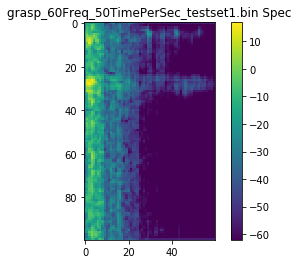

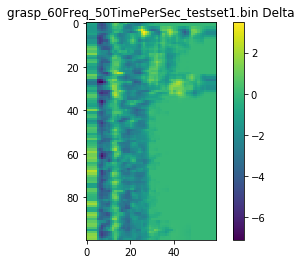

Category:  egg
Object:  egg_rough_styrofoam


In [5]:
"""
Display a frame of the sound dataset
"""

batch_no = 188

print("batch, frames, freq, channel:", audio_frames_2d_train.shape)

print_image(audio_frames_2d_train[batch_no, :, :, 0], db_file_name+" Spec")
print_image(audio_frames_2d_train[batch_no, :, :, 1], db_file_name+" Delta")

print("Category: ", list(category_labels.keys())[list(category_labels.values()).index(category_label_train[batch_no])])
print("Object: ", list(object_labels.keys())[list(object_labels.values()).index(object_label_train[batch_no])])

## Building the Sound Network Architecture

![Sound Network Architecture](pics/Sound_CNN.png)

## Sound Network Hyper-parameters

We applied dropout with 0.5 probability for fully connected layers and the first convolutional layer.
We trained our network using Adam optimization, with a learning rate 1 x $10^{-4}$ and stopped training after 300 iterations.

In [6]:
# Network hyper-parameters
batch = 1
training_epochs = 300
display_step = 1

frames = time_step_size = audio_frames_2d_train.shape[1]
freq_height = audio_frames_2d_train.shape[2]
channel = audio_frames_2d_train.shape[3]

num_classes = category_label_train_one_not.shape[1]

model_path = db_file_name.split(".")[0]+"_logs/model.ckpt"
logs_path = db_file_name.split(".")[0]+"_logs/"

Y = tf.placeholder('float', [None, num_classes], name='LabelData')
keep_prob = tf.placeholder_with_default(1.0, shape=(), name = 'keep')

In [7]:
"""
Functions used to define models
"""

def model():
    with tf.name_scope("Model"):
        data_placeholder = tf.placeholder('float', [None, frames, freq_height, channel], name='InputData')
        
        net = tf.layers.conv2d(inputs=data_placeholder, filters=20, kernel_size=[57, 6], strides=[1, 1], padding="same", activation=tf.nn.relu)
        net = tf.layers.max_pooling2d(inputs=net, pool_size=[4, 4], strides=[4, 4])
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        net = tf.layers.conv2d(inputs=net, filters=40, kernel_size=[1, 3], strides=[1, 1], padding="same", activation=tf.nn.relu)
        if (db_file_name.split("_")[0]) == "hold":
            net = tf.layers.max_pooling2d(inputs=net, pool_size=[1, 4], strides=[1, 4])
        else:
            net = tf.layers.max_pooling2d(inputs=net, pool_size=[4, 4], strides=[4, 4])
        net = tf.layers.flatten(net)
        # Dense Layer
        net = tf.layers.dense(inputs=net, units=256, activation=tf.nn.relu)
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        net = tf.layers.dense(inputs=net, units=256, activation=tf.nn.relu)
        net = tf.layers.dropout(inputs=net, rate=keep_prob)
        logits = tf.layers.dense(inputs=net, units=num_classes)
        
    return logits

def loss(prediction, label_placeholder):
    with tf.name_scope('Loss'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=label_placeholder))
        # Create a summary to monitor cost tensor
        cost_scalar = tf.summary.scalar("loss", cost)
    return cost, cost_scalar

def training(prediction, label_placeholder):
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(cost)
    return train_op

def evaluate(prediction, Y):
    with tf.name_scope('Accuracy'):
        # Test model
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        # Create a summary to monitor accuracy tensor
        accuracy_scalar = tf.summary.scalar("accuracy", accuracy)
    return accuracy, accuracy_scalar

In [8]:
"""
Creating the Neural Network
"""

model_dict = {}

prediction = model()
model_dict["Model"] = prediction

cost, cost_scalar = loss(prediction, Y)
model_dict["Loss"] = cost
model_dict["Loss_scalar"] = cost_scalar

train_op = training(prediction, Y)
model_dict["Optimizer"] = train_op

eval_op, accuracy_scalar = evaluate(prediction, Y)
model_dict["Accuracy"] = eval_op
model_dict["Accuracy_scalar"] = accuracy_scalar

print("model_dict: ", model_dict)

# Initializing the variables
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)

model_dict:  {'Model': <tf.Tensor 'Model/dense_2/BiasAdd:0' shape=(?, 20) dtype=float32>, 'Loss': <tf.Tensor 'Loss/Mean:0' shape=() dtype=float32>, 'Loss_scalar': <tf.Tensor 'Loss/loss:0' shape=() dtype=string>, 'Optimizer': <tf.Operation 'Optimizer/Adam' type=NoOp>, 'Accuracy': <tf.Tensor 'Accuracy/Mean:0' shape=() dtype=float32>, 'Accuracy_scalar': <tf.Tensor 'Accuracy/accuracy:0' shape=() dtype=string>}


## Testing for the whole sound clip

In [9]:
# Evaluate on test set

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, tf.train.latest_checkpoint(logs_path))
    
    avg_accuracy_list = 0.0
    total_batch = int(len(audio_frames_2d_test)/batch)
    
    for start, end in zip(range(0, len(audio_frames_2d_test), batch), range(batch, len(audio_frames_2d_test)+1, batch)):
        X = tf.get_default_graph().get_tensor_by_name("Model/InputData:0")
        input_data, label_data = audio_frames_2d_test[start:end], category_label_test_one_not[start:end]
        accuracy = sess.run(model_dict["Accuracy"], feed_dict={X: input_data, Y: label_data})
        avg_accuracy_list += accuracy/total_batch
    
    print("Overall Accuracy: ", avg_accuracy_list)

INFO:tensorflow:Restoring parameters from grasp_60Freq_50TimePerSec_testset1_logs/model.ckpt-299
Overall Accuracy:  0.47000000000000025


## Testing for every 5th frame in the sound clip

In [10]:
# Predict after every 5th frame of a audio

all_frames_acc = {}
for a_frame in range(5, frames+1, 5):
    all_frames_acc[a_frame] = [0, 0, 0] # correct, wrong, percentage

y_pred = {}
y_score = {}
for a_frame in range(5, frames+ 1, 5):
    y_pred[a_frame] = []
    y_score[a_frame] = []

def fill_example(example, fill_frames, a_frame):
    temp = []
    temp.append(example[a_frame-1])
    for _ in range(fill_frames):
        example = np.concatenate((example, temp))
    return example

def give_me_complete_clip(num_of_frame, example):
    fill_frames = frames - num_of_frame
    if fill_frames != 0:
        example = fill_example(example, fill_frames, num_of_frame)
    return example

with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, tf.train.latest_checkpoint(logs_path))
    
    for i_example in range(len(audio_frames_2d_test)):
        print("Example Number: ", i_example+1)
        input_data, label_data = audio_frames_2d_test[i_example], category_label_test_one_not[i_example]
        
        truth = np.argmax(label_data, 0)+1
        truth_cate = list(category_labels.keys())[list(category_labels.values()).index(truth)]
        print("True Category: ", truth_cate)
        
        for a_frame in range(5, frames+1, 5):
            
            example = give_me_complete_clip(a_frame, input_data[0:a_frame])
            
            temp = []
            temp.append(example)
            
            X = tf.get_default_graph().get_tensor_by_name("Model/InputData:0")
            predic = sess.run(model_dict["Model"], feed_dict={X: temp, keep_prob: 1.0})
            
            argmax = sess.run(tf.argmax(predic, 1))+1
            cate = list(category_labels.keys())[list(category_labels.values()).index(argmax)]
            print("Frame No.: ", a_frame, "Prediction: ", cate)
            
            y_pred[a_frame].extend(argmax)
            y_score[a_frame].extend(predic)
            
            if truth_cate == cate:
                all_frames_acc[a_frame][0] += 1
            else:
                all_frames_acc[a_frame][1] += 1
            all_frames_acc[a_frame][2] = all_frames_acc[a_frame][0]/(all_frames_acc[a_frame][0]+all_frames_acc[a_frame][1])
            
        print("X"*50)

INFO:tensorflow:Restoring parameters from grasp_60Freq_50TimePerSec_testset1_logs/model.ckpt-299
Example Number:  1
True Category:  ball
Frame No.:  5 Prediction:  bigstuffedanimal
Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  bottle
Frame No.:  20 Prediction:  egg
Frame No.:  25 Prediction:  egg
Frame No.:  30 Prediction:  bottle
Frame No.:  35 Prediction:  bottle
Frame No.:  40 Prediction:  bottle
Frame No.:  45 Prediction:  bottle
Frame No.:  50 Prediction:  bottle
Frame No.:  55 Prediction:  bottle
Frame No.:  60 Prediction:  bottle
Frame No.:  65 Prediction:  bottle
Frame No.:  70 Prediction:  bottle
Frame No.:  75 Prediction:  bottle
Frame No.:  80 Prediction:  bottle
Frame No.:  85 Prediction:  bottle
Frame No.:  90 Prediction:  bottle
Frame No.:  95 Prediction:  bottle
Frame No.:  100 Prediction:  bottle
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  2
True Category:  ball
Frame No.:  5 Prediction:  ball
Frame No.:  10 Prediction:

Frame No.:  5 Prediction:  smallstuffedanimal
Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  ball
Frame No.:  25 Prediction:  bigstuffedanimal
Frame No.:  30 Prediction:  bigstuffedanimal
Frame No.:  35 Prediction:  smallstuffedanimal
Frame No.:  40 Prediction:  bigstuffedanimal
Frame No.:  45 Prediction:  bigstuffedanimal
Frame No.:  50 Prediction:  bigstuffedanimal
Frame No.:  55 Prediction:  smallstuffedanimal
Frame No.:  60 Prediction:  bigstuffedanimal
Frame No.:  65 Prediction:  bigstuffedanimal
Frame No.:  70 Prediction:  smallstuffedanimal
Frame No.:  75 Prediction:  bigstuffedanimal
Frame No.:  80 Prediction:  bigstuffedanimal
Frame No.:  85 Prediction:  bigstuffedanimal
Frame No.:  90 Prediction:  bigstuffedanimal
Frame No.:  95 Prediction:  bigstuffedanimal
Frame No.:  100 Prediction:  bigstuffedanimal
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  12
True Category:  bigstuffedanimal
Frame No.:  

Frame No.:  50 Prediction:  cup
Frame No.:  55 Prediction:  medicine
Frame No.:  60 Prediction:  cannedfood
Frame No.:  65 Prediction:  cannedfood
Frame No.:  70 Prediction:  cup
Frame No.:  75 Prediction:  medicine
Frame No.:  80 Prediction:  cup
Frame No.:  85 Prediction:  cup
Frame No.:  90 Prediction:  cup
Frame No.:  95 Prediction:  cup
Frame No.:  100 Prediction:  cup
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  21
True Category:  can
Frame No.:  5 Prediction:  bigstuffedanimal
Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  bigstuffedanimal
Frame No.:  20 Prediction:  bottle
Frame No.:  25 Prediction:  egg
Frame No.:  30 Prediction:  egg
Frame No.:  35 Prediction:  egg
Frame No.:  40 Prediction:  egg
Frame No.:  45 Prediction:  egg
Frame No.:  50 Prediction:  egg
Frame No.:  55 Prediction:  egg
Frame No.:  60 Prediction:  egg
Frame No.:  65 Prediction:  egg
Frame No.:  70 Prediction:  egg
Frame No.:  75 Prediction:  egg
Frame No.: 

Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  egg
Frame No.:  25 Prediction:  egg
Frame No.:  30 Prediction:  egg
Frame No.:  35 Prediction:  bottle
Frame No.:  40 Prediction:  bottle
Frame No.:  45 Prediction:  cup
Frame No.:  50 Prediction:  cup
Frame No.:  55 Prediction:  cup
Frame No.:  60 Prediction:  cup
Frame No.:  65 Prediction:  cup
Frame No.:  70 Prediction:  cup
Frame No.:  75 Prediction:  cup
Frame No.:  80 Prediction:  cup
Frame No.:  85 Prediction:  cup
Frame No.:  90 Prediction:  cup
Frame No.:  95 Prediction:  cup
Frame No.:  100 Prediction:  cup
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  32
True Category:  cone
Frame No.:  5 Prediction:  smallstuffedanimal
Frame No.:  10 Prediction:  egg
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  smallstuffedanimal
Frame No.:  25 Prediction:  bigstuffedanimal
Frame No.:  30 Prediction:  bigstuffedanimal
Frame No.:  35 Prediction:  bal

Frame No.:  5 Prediction:  bottle
Frame No.:  10 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  bigstuffedanimal
Frame No.:  25 Prediction:  bottle
Frame No.:  30 Prediction:  egg
Frame No.:  35 Prediction:  egg
Frame No.:  40 Prediction:  cannedfood
Frame No.:  45 Prediction:  cannedfood
Frame No.:  50 Prediction:  cannedfood
Frame No.:  55 Prediction:  pasta
Frame No.:  60 Prediction:  cannedfood
Frame No.:  65 Prediction:  cannedfood
Frame No.:  70 Prediction:  cannedfood
Frame No.:  75 Prediction:  cannedfood
Frame No.:  80 Prediction:  cannedfood
Frame No.:  85 Prediction:  cannedfood
Frame No.:  90 Prediction:  cannedfood
Frame No.:  95 Prediction:  cannedfood
Frame No.:  100 Prediction:  cannedfood
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  42
True Category:  eggcoloringcup
Frame No.:  5 Prediction:  bottle
Frame No.:  10 Prediction:  noodle
Frame No.:  15 Prediction:  noodle
Frame No.:  20 Prediction:  smallstuffedanimal


Frame No.:  25 Prediction:  egg
Frame No.:  30 Prediction:  pvc
Frame No.:  35 Prediction:  can
Frame No.:  40 Prediction:  medicine
Frame No.:  45 Prediction:  medicine
Frame No.:  50 Prediction:  medicine
Frame No.:  55 Prediction:  medicine
Frame No.:  60 Prediction:  medicine
Frame No.:  65 Prediction:  medicine
Frame No.:  70 Prediction:  medicine
Frame No.:  75 Prediction:  medicine
Frame No.:  80 Prediction:  medicine
Frame No.:  85 Prediction:  medicine
Frame No.:  90 Prediction:  medicine
Frame No.:  95 Prediction:  medicine
Frame No.:  100 Prediction:  medicine
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  52
True Category:  medicine
Frame No.:  5 Prediction:  ball
Frame No.:  10 Prediction:  egg
Frame No.:  15 Prediction:  egg
Frame No.:  20 Prediction:  pvc
Frame No.:  25 Prediction:  egg
Frame No.:  30 Prediction:  timber
Frame No.:  35 Prediction:  pvc
Frame No.:  40 Prediction:  medicine
Frame No.:  45 Prediction:  medicine
Frame No.:  50 Prediction

Frame No.:  55 Prediction:  egg
Frame No.:  60 Prediction:  ball
Frame No.:  65 Prediction:  noodle
Frame No.:  70 Prediction:  eggcoloringcup
Frame No.:  75 Prediction:  eggcoloringcup
Frame No.:  80 Prediction:  eggcoloringcup
Frame No.:  85 Prediction:  eggcoloringcup
Frame No.:  90 Prediction:  eggcoloringcup
Frame No.:  95 Prediction:  eggcoloringcup
Frame No.:  100 Prediction:  eggcoloringcup
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  62
True Category:  noodle
Frame No.:  5 Prediction:  smallstuffedanimal
Frame No.:  10 Prediction:  bigstuffedanimal
Frame No.:  15 Prediction:  bigstuffedanimal
Frame No.:  20 Prediction:  bigstuffedanimal
Frame No.:  25 Prediction:  timber
Frame No.:  30 Prediction:  bottle
Frame No.:  35 Prediction:  smallstuffedanimal
Frame No.:  40 Prediction:  noodle
Frame No.:  45 Prediction:  noodle
Frame No.:  50 Prediction:  cone
Frame No.:  55 Prediction:  noodle
Frame No.:  60 Prediction:  noodle
Frame No.:  65 Prediction:  noodl

Frame No.:  85 Prediction:  cup
Frame No.:  90 Prediction:  cup
Frame No.:  95 Prediction:  cup
Frame No.:  100 Prediction:  cup
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  72
True Category:  pvc
Frame No.:  5 Prediction:  cone
Frame No.:  10 Prediction:  egg
Frame No.:  15 Prediction:  egg
Frame No.:  20 Prediction:  egg
Frame No.:  25 Prediction:  pvc
Frame No.:  30 Prediction:  timber
Frame No.:  35 Prediction:  timber
Frame No.:  40 Prediction:  egg
Frame No.:  45 Prediction:  pvc
Frame No.:  50 Prediction:  cannedfood
Frame No.:  55 Prediction:  cup
Frame No.:  60 Prediction:  cannedfood
Frame No.:  65 Prediction:  cannedfood
Frame No.:  70 Prediction:  cup
Frame No.:  75 Prediction:  cannedfood
Frame No.:  80 Prediction:  cup
Frame No.:  85 Prediction:  pvc
Frame No.:  90 Prediction:  cup
Frame No.:  95 Prediction:  pvc
Frame No.:  100 Prediction:  pvc
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  73
True Category:  pvc
Frame No.:  5 

Frame No.:  70 Prediction:  timber
Frame No.:  75 Prediction:  timber
Frame No.:  80 Prediction:  timber
Frame No.:  85 Prediction:  timber
Frame No.:  90 Prediction:  timber
Frame No.:  95 Prediction:  timber
Frame No.:  100 Prediction:  timber
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  82
True Category:  timber
Frame No.:  5 Prediction:  bigstuffedanimal
Frame No.:  10 Prediction:  metal
Frame No.:  15 Prediction:  bigstuffedanimal
Frame No.:  20 Prediction:  bigstuffedanimal
Frame No.:  25 Prediction:  noodle
Frame No.:  30 Prediction:  timber
Frame No.:  35 Prediction:  noodle
Frame No.:  40 Prediction:  timber
Frame No.:  45 Prediction:  timber
Frame No.:  50 Prediction:  timber
Frame No.:  55 Prediction:  timber
Frame No.:  60 Prediction:  timber
Frame No.:  65 Prediction:  timber
Frame No.:  70 Prediction:  timber
Frame No.:  75 Prediction:  timber
Frame No.:  80 Prediction:  timber
Frame No.:  85 Prediction:  timber
Frame No.:  90 Prediction:  timber
Fr

Frame No.:  10 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  bigstuffedanimal
Frame No.:  25 Prediction:  bottle
Frame No.:  30 Prediction:  eggcoloringcup
Frame No.:  35 Prediction:  bottle
Frame No.:  40 Prediction:  eggcoloringcup
Frame No.:  45 Prediction:  eggcoloringcup
Frame No.:  50 Prediction:  tupperware
Frame No.:  55 Prediction:  tupperware
Frame No.:  60 Prediction:  eggcoloringcup
Frame No.:  65 Prediction:  tupperware
Frame No.:  70 Prediction:  eggcoloringcup
Frame No.:  75 Prediction:  tupperware
Frame No.:  80 Prediction:  eggcoloringcup
Frame No.:  85 Prediction:  eggcoloringcup
Frame No.:  90 Prediction:  eggcoloringcup
Frame No.:  95 Prediction:  eggcoloringcup
Frame No.:  100 Prediction:  eggcoloringcup
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Example Number:  93
True Category:  tupperware
Frame No.:  5 Prediction:  ball
Frame No.:  10 Prediction:  ball
Frame No.:  15 Prediction:  ball
Frame No.:  20 Prediction:  ball
Fra

In [11]:
"""
Writing a CSV file that records accuracy for each frame
"""

with open(logs_path+db_file_name.split(".")[0]+"_acc_every_frame.csv",'w') as f:
    writer = csv.writer(f, lineterminator="\n")
    
    first_row = ["Frame_No", "Correct", "Wrong", "Accuracy"]
    writer.writerow(first_row)
    for a_frame in range(5, frames+1, 5):
        row = [a_frame]
        row.append(all_frames_acc[a_frame][0])
        row.append(all_frames_acc[a_frame][1])
        row.append(all_frames_acc[a_frame][2])
        writer.writerow(row)